In [1]:

import yfinance as yf
import pandas as pd
from pandas_datareader import data as pdr
import numpy as np
import matplotlib.pyplot as plt


In [2]:

begin = '2010-01-01'
yf.pdr_override() 
ticker = 'PG'
df = pdr.get_data_yahoo(ticker, begin)
df

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2010-01-04,61.110001,61.310001,60.630001,61.119999,41.181232,9190800
2010-01-05,61.130001,61.279999,60.599998,61.139999,41.194717,8649400
2010-01-06,60.939999,60.959999,60.500000,60.849998,40.999302,9908400
2010-01-07,60.580002,60.700001,60.240002,60.520000,40.776958,8972800
2010-01-08,60.360001,60.529999,60.060001,60.439999,40.723068,8464600
...,...,...,...,...,...,...
2023-03-22,144.039993,145.750000,143.830002,143.990005,143.990005,5729100
2023-03-23,144.240005,145.119995,143.190002,143.789993,143.789993,5788400
2023-03-24,144.300003,146.759995,144.300003,146.720001,146.720001,6144800


<Axes: xlabel='Date'>

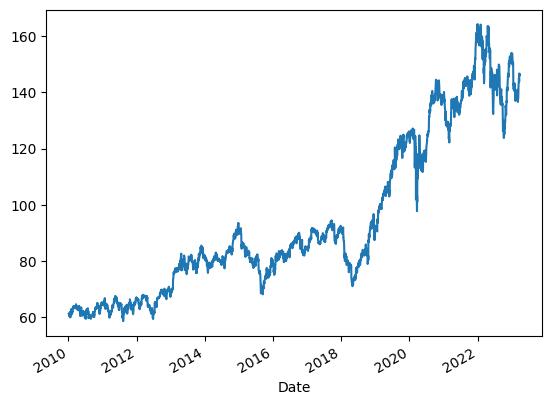

In [3]:
close = df['Close']

close.plot()

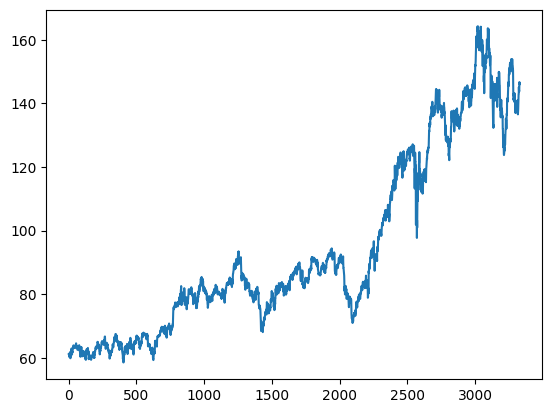

In [4]:
ds = close.values
plt.plot(ds)

In [5]:
from sklearn.preprocessing import MinMaxScaler

In [6]:
#Using MinMaxScaler for normalizing data between 0 & 1
normalizer = MinMaxScaler(feature_range=(0,1))
ds_scaled = normalizer.fit_transform(np.array(ds).reshape(-1,1))

In [7]:
#Defining test and train data sizes
train_size = int(len(ds_scaled)*0.70) # train set is 70%
test_size = len(ds_scaled) - train_size # test is the other 30%


In [8]:
#Splitting data between train and test
ds_train, ds_test = ds_scaled[0:train_size,:], ds_scaled[train_size:len(ds_scaled),: 1]

In [9]:
#creating dataset in time series for LSTM model 
def create_ds(dataset,step):
    Xtrain, Ytrain = [], []
    for i in range(len(dataset)-step-1):
        a = dataset[i:(i+step), 0]
        Xtrain.append(a)
        Ytrain.append(dataset[i + step, 0])
    return np.array(Xtrain), np.array(Ytrain)

In [10]:
#Taking 100 days price as one record for training
time_stamp = 100
X_train, y_train = create_ds(ds_train,time_stamp)
X_test, y_test = create_ds(ds_test,time_stamp)

In [11]:
#Reshaping data to fit into LSTM model
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [12]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

2023-03-28 17:34:57.007316: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
#Creating LSTM model using keras
model = Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1],1)))
model.add(LSTM(units=50,return_sequences=True))
model.add(LSTM(units=50))
model.add(Dense(units=1,activation='linear'))
model.summary()

2023-03-28 17:34:59.129229: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [14]:
#Training model with adam optimizer and mean squared error loss function
model.compile(loss='mean_squared_error',optimizer='adam')
model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=100,batch_size=64)

Epoch 1/100
35/35 [==============================] - 7s 136ms/step - loss: 0.0059 - val_loss: 0.0036
Epoch 2/100
35/35 [==============================] - 4s 123ms/step - loss: 4.4775e-04 - val_loss: 0.0041
Epoch 3/100
35/35 [==============================] - 4s 118ms/step - loss: 3.5908e-04 - val_loss: 0.0030
Epoch 4/100
35/35 [==============================] - 4s 125ms/step - loss: 3.3008e-04 - val_loss: 0.0017
Epoch 5/100
35/35 [==============================] - 4s 122ms/step - loss: 3.3002e-04 - val_loss: 0.0016
Epoch 6/100
35/35 [==============================] - 4s 119ms/step - loss: 2.9440e-04 - val_loss: 0.0015
Epoch 7/100
35/35 [==============================] - 4s 120ms/step - loss: 2.9560e-04 - val_loss: 0.0017
Epoch 8/100
35/35 [==============================] - 4s 123ms/step - loss: 2.7305e-04 - val_loss: 0.0015
Epoch 9/100
35/35 [==============================] - 4s 122ms/step - loss: 2.6196e-04 - val_loss: 0.0016
Epoch 10/100
35/35 [==============================] - 4s 11

35/35 [==============================] - 4s 126ms/step - loss: 7.9503e-05 - val_loss: 0.0010
Epoch 78/100
35/35 [==============================] - 4s 121ms/step - loss: 6.5580e-05 - val_loss: 7.5411e-04
Epoch 79/100
35/35 [==============================] - 4s 122ms/step - loss: 6.4025e-05 - val_loss: 8.2553e-04
Epoch 80/100
35/35 [==============================] - 4s 121ms/step - loss: 6.3743e-05 - val_loss: 0.0019
Epoch 81/100
35/35 [==============================] - 4s 125ms/step - loss: 7.4002e-05 - val_loss: 0.0013
Epoch 82/100
35/35 [==============================] - 4s 121ms/step - loss: 7.4956e-05 - val_loss: 4.5003e-04
Epoch 83/100
35/35 [==============================] - 4s 123ms/step - loss: 6.6229e-05 - val_loss: 4.3463e-04
Epoch 84/100
35/35 [==============================] - 4s 119ms/step - loss: 6.1578e-05 - val_loss: 7.3829e-04
Epoch 85/100
35/35 [==============================] - 4s 119ms/step - loss: 6.5938e-05 - val_loss: 9.0452e-04
Epoch 86/100
35/35 [===============

In [32]:
#PLotting loss, it shows that loss has decreased significantly and model trained well
loss = model.history.history['loss']
plt.plot(loss, label='Loss')


KeyError: 'loss'

In [33]:
#Predicitng on train and test data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

29/29 [==============================] - 1s 23ms/step


In [17]:
#Inverse transform to get actual value
train_predict = normalizer.inverse_transform(train_predict)
test_predict = normalizer.inverse_transform(test_predict)

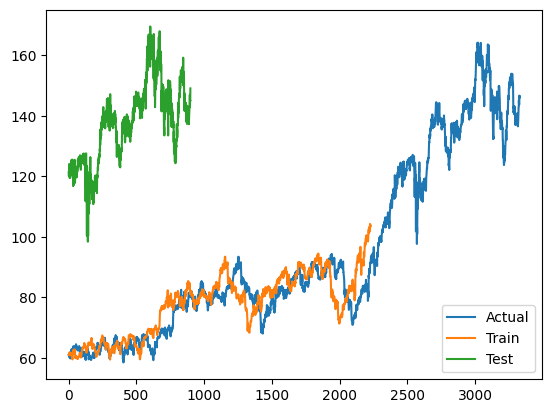

In [18]:
#Comparing using visuals
plt.plot(normalizer.inverse_transform(ds_scaled), label="Actual")
plt.plot(train_predict, label="Train")
plt.plot(test_predict, label="Test")
plt.legend()

In [19]:
test = np.vstack((train_predict,test_predict))

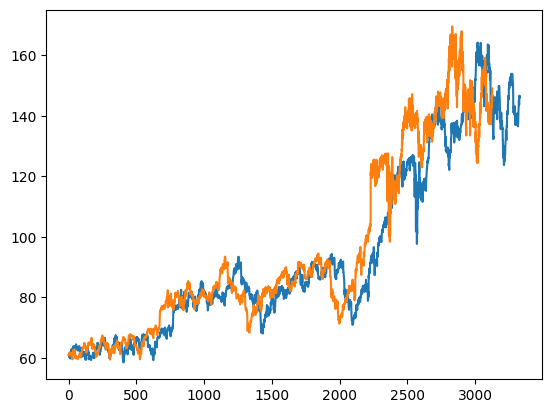

In [20]:
#Combining the predited data to create uniform data visualization
plt.plot(normalizer.inverse_transform(ds_scaled))
plt.plot(test, label='Test')

In [21]:
#Getting the last 100 days records
fut_inp = ds_test[900:]
print(len(fut_inp))

100


In [22]:
fut_inp = fut_inp.reshape(1,-1)
tmp_inp = list(fut_inp)

#Creating list of the last 728 data
tmp_inp = tmp_inp[0].tolist()

In [23]:
#Predicting next 30 days price suing the current data
#It will predict in sliding window manner (algorithm) with stride 1
lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(tmp_inp)>100):
        fut_inp = np.array(tmp_inp[1:])
        fut_inp=fut_inp.reshape(1,-1)
        fut_inp = fut_inp.reshape((1, n_steps, 1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        tmp_inp = tmp_inp[1:]
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        fut_inp = fut_inp.reshape((1, n_steps,1))
        yhat = model.predict(fut_inp, verbose=0)
        tmp_inp.extend(yhat[0].tolist())
        lst_output.extend(yhat.tolist())
        i=i+1
print(lst_output)

print(len(ds_scaled))

[[0.8478990197181702], [0.8677659630775452], [0.8761711716651917], [0.8823422789573669], [0.8911671042442322], [0.901980459690094], [0.9130484461784363], [0.9239022731781006], [0.934882640838623], [0.9462419748306274], [0.9579398036003113], [0.9698585867881775], [0.9819564819335938], [0.9942521452903748], [1.0067611932754517], [1.019476056098938], [1.0323797464370728], [1.0454602241516113], [1.0587104558944702], [1.0721217393875122], [1.0856822729110718], [1.0993784666061401], [1.1131953001022339], [1.1271182298660278], [1.14113187789917], [1.1552201509475708], [1.1693648099899292], [1.1835463047027588], [1.1977449655532837], [1.2119412422180176]]
3331


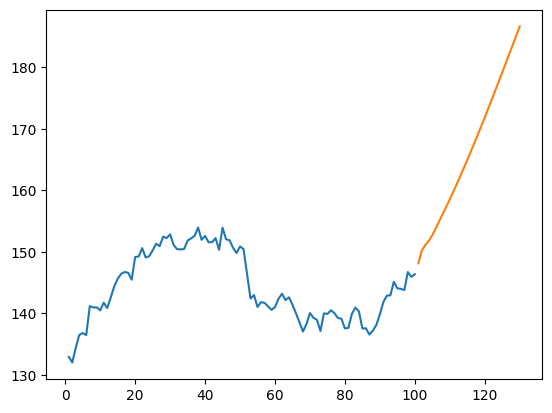

In [24]:
#Creating a dummy plane to plot graph one after another
plot_new=np.arange(1,101)
plot_pred=np.arange(101,131)
plt.plot(plot_new, normalizer.inverse_transform(ds_scaled[3231:]))
plt.plot(plot_pred, normalizer.inverse_transform(lst_output))

3361


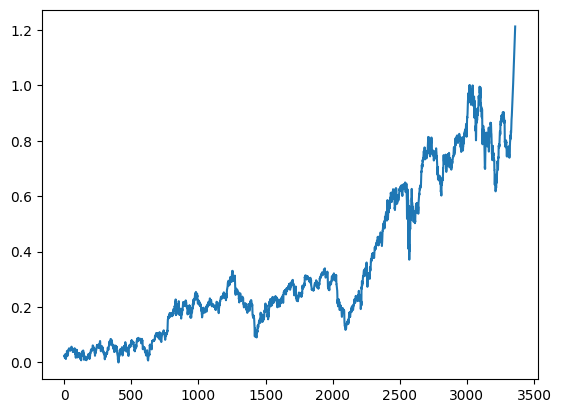

In [25]:
ds_new = ds_scaled.tolist()
#Entends helps us to fill the missing value with approx value
ds_new.extend(lst_output)
plt.plot(ds_new)
print(len(ds_new))

In [26]:
#Creating final data for plotting
final_graph = normalizer.inverse_transform(ds_new).tolist()


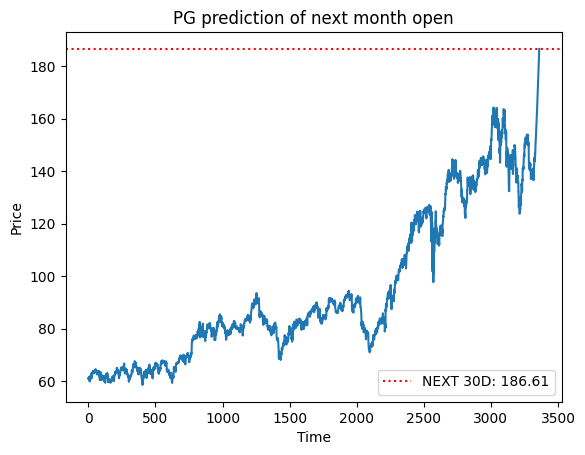

In [27]:
#Plotting final results with predicted value after 30 Days
plt.plot(final_graph,)
plt.ylabel("Price")
plt.xlabel("Time")
plt.title("{0} prediction of next month open".format(ticker))
plt.axhline(y=final_graph[len(final_graph)-1], color = 'red', linestyle = ':', label = 'NEXT 30D: {0}'.format(round(float(*final_graph[len(final_graph)-1]),2)))
plt.legend()


In [28]:
ONNXModelPath = "../Users/antoinesfeir/Documents/GitHub/SWMG/QuantU/wwwroot/ml"

from onnx import __version__, IR_VERSION
from onnx.defs import onnx_opset_version
print(f"onnx.__version__={__version__!r}, opset={onnx_opset_version()}, IR_VERSION={IR_VERSION}")

onnx.__version__='1.13.1', opset=18, IR_VERSION=8


In [29]:
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import FloatTensorType
import onnxruntime as rt

In [30]:
num_features = 1
intitial_type = [('feature_input', FloatTensorType([None, num_features]))]
onx = convert_sklearn(model, intitial_types=intitial_type)
with open(ONNXModelPath, "wb") as f:
    f.write(onx.SerializeToString())

TypeError: convert_sklearn() got an unexpected keyword argument 'intitial_types'